## Reprocess molecule info H5 file

In [505]:
%matplotlib inline

import os
import sys
notebook_path = os.path.abspath('')
sources_path = os.path.abspath(os.path.join(notebook_path, '..', 'sources'))
sys.path.insert(0, sources_path)

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import itertools
import operator
from bisect import bisect_left, bisect_right
from commons import *

plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

In [506]:
# select dataset
mol_h5_path = '/home/jupyter/data/10x/pbmc4k_molecule_info.h5'
genes_tsv_path = None
cr_version = 'v2'

In [ ]:
mol_info = MoleculeInfo(mol_h5_path, cr_version, genes_tsv_path, extended=True)

## Greedy assignment of unmapped and non-confidently mapped molecules

- Iterate over (CB, UMI)
- Pick the gene with the highest number of confidently mapped reads with unique positions
- Assign all reads associated to (CB, UMI) to that gene (including unmapped and non-confidently mapped)
- If no single gene has the highest number of confidently mapped reads with unique positions, pick the gene
  with the highest (naïve) count in the experiment

In [ ]:
from collections import Counter
from operator import itemgetter
from itertools import groupby
from collections import defaultdict

gene_counter = Counter(mol_info.gene_array)

In [ ]:
n_genes = len(mol_info.gene_names_array)
gene_counts_list = [gene_counter[gene_index] for gene_index in range(n_genes)]
sorted_gene_indices_by_expression = sorted(enumerate(gene_counts_list), key=itemgetter(1), reverse=True)
gene_ranks_reverse = {sorted_gene_indices_by_expression[rank][0]: rank for rank in range(n_genes)}
gene_ranks = list(map(gene_ranks_reverse.get, range(n_genes)))

# higher score = higher expression; unmapped has score = 0
gene_scores = np.zeros((n_genes + 1,), dtype=np.uint32)
gene_scores[:n_genes] = n_genes - np.asarray(gene_ranks)
gene_scores[n_genes] = 0

In [ ]:
log_frequency = 100_000
merged_barcode_list = []
merged_umi_list = []
merged_gene_list = []
merged_reads_list = []
conf_mapped_fraction_list = []
read_to_read_conversion_matrix = np.zeros((1000, 1000))

i_group = 0
for group, entries in groupby(enumerate(zip(mol_info.barcode_array, mol_info.umi_array)), key=itemgetter(1)):

    mol_indices = list(map(itemgetter(0), entries))
    c_conf_mapped_uniq_read_pos = mol_info.conf_mapped_uniq_read_pos_array[mol_indices]
    c_genes = mol_info.gene_array[mol_indices]
    c_gene_scores = gene_scores[c_genes]
    
    selected_mol_idx = mol_indices[max(enumerate(zip(c_conf_mapped_uniq_read_pos, c_gene_scores)), key=itemgetter(1))[0]]
    selected_gene = mol_info.gene_array[selected_mol_idx]
    
    summed_conf_mapped_reads = np.sum(mol_info.reads_array[mol_indices])
    summed_nonconf_mapped_reads = np.sum(mol_info.nonconf_mapped_reads_array[mol_indices])
    summed_unmapped_reads = np.sum(mol_info.unmapped_reads_array[mol_indices])
    
    total_reads = summed_conf_mapped_reads + summed_nonconf_mapped_reads + summed_unmapped_reads
    total_mapped_reads = summed_conf_mapped_reads + summed_nonconf_mapped_reads
    conf_mapped_fraction = mol_info.reads_array[selected_mol_idx] / total_reads
    
    merged_barcode_list.append(group[0])
    merged_umi_list.append(group[1])
    merged_gene_list.append(selected_gene)
    merged_reads_list.append(total_mapped_reads)
    conf_mapped_fraction_list.append(conf_mapped_fraction)
    
    for mol_index in mol_indices:
        if mol_info.gene_array[mol_index] == selected_gene:
            read_to_read_conversion_matrix[mol_info.reads_array[selected_mol_idx], total_mapped_reads] += 1
        elif mol_info.gene_array[mol_index] != mol_info.unmappable_gene_idx:
            read_to_read_conversion_matrix[mol_info.reads_array[selected_mol_idx], 0] += 1
            
    i_group += 1
    if i_group > 0 and i_group % log_frequency == 0:
        print(f'{i_group}...')

## Estimating per-gene multi-mapping metric

In [503]:
log_frequency = 1_000_000
conf_mapped_reads_per_consensus_gene = np.zeros((n_genes + 1,))
all_reads_per_consensus_gene = np.zeros((n_genes + 1,))
consensus_gene_list = []
n_real_collisions = 0
i_group = 0

for group, entries in groupby(enumerate(zip(mol_info.barcode_array, mol_info.umi_array)), key=itemgetter(1)):

    mol_indices = list(map(itemgetter(0), entries))
    c_conf_mapped_uniq_read_pos = mol_info.conf_mapped_uniq_read_pos_array[mol_indices]
    c_genes = mol_info.gene_array[mol_indices]
    c_gene_scores = gene_scores[c_genes]
    
    selected_mol_idx = mol_indices[max(enumerate(zip(c_conf_mapped_uniq_read_pos, c_gene_scores)), key=itemgetter(1))[0]]
    selected_gene = mol_info.gene_array[selected_mol_idx]
    
    if len(mol_indices) > 1:
        summed_conf_mapped_reads = np.sum(mol_info.reads_array[mol_indices])
        summed_nonconf_mapped_reads = np.sum(mol_info.nonconf_mapped_reads_array[mol_indices])
        summed_unmapped_reads = np.sum(mol_info.unmapped_reads_array[mol_indices])

        total_reads = summed_conf_mapped_reads + summed_nonconf_mapped_reads + summed_unmapped_reads
        selected_gene_conf_mapped_reads = mol_info.reads_array[selected_mol_idx]
    
    else:
        
        total_reads = (mol_info.reads_array[mol_indices[0]] +
                       mol_info.nonconf_mapped_reads_array[mol_indices[0]] +
                       mol_info.unmapped_reads_array[mol_indices[0]])
        selected_gene_conf_mapped_reads = mol_info.reads_array[selected_mol_idx]
    
    if selected_gene_conf_mapped_reads < summed_conf_mapped_reads:
        n_real_collisions += 1
        
    conf_mapped_reads_per_consensus_gene[selected_gene] += selected_gene_conf_mapped_reads
    all_reads_per_consensus_gene[selected_gene] += total_reads
    consensus_gene_list.append(selected_gene)

    i_group += 1
    if i_group > 0 and i_group % log_frequency == 0:
        print(f'{i_group}...')

1000000...
2000000...
3000000...


KeyboardInterrupt: 

In [504]:
n_real_collisions / i_group

0.5872350364770039

In [442]:
conf_mapped_ratio_per_gene = (1e-8 + conf_mapped_reads_per_consensus_gene) / (1e-8 + all_reads_per_consensus_gene)

In [443]:
consensus_genes_set = np.unique(consensus_gene_list)

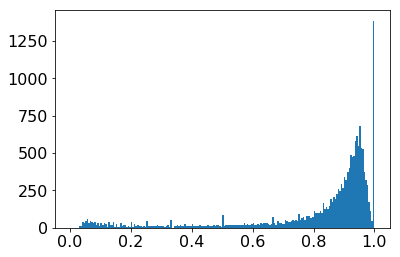

In [507]:
plt.hist(conf_mapped_ratio_per_gene[consensus_genes_set], bins=200);

(1, 1000000.0)

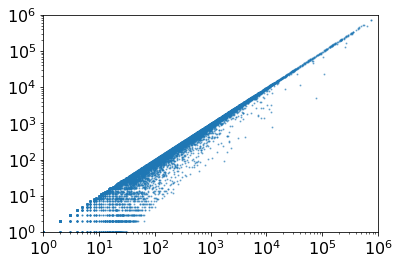

In [499]:
plt.scatter(all_reads_per_consensus_gene[:-1], conf_mapped_reads_per_consensus_gene[:-1], s=1, alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlim((1, 1e6))
plt.ylim((1, 1e6))

In [ ]:
i = 14009
# gene_index = sorted_gene_indices_by_expression[i][0]

gene_index = mol_info.gene_names_array.tolist().index(b'MYLK3')
print(mol_info.gene_names_array[gene_index])
print(conf_mapped_ratio_per_gene[gene_index])

In [478]:
conf_mapped_reads_per_consensus_gene[gene_index]

5.0

In [479]:
all_reads_per_consensus_gene[gene_index]

34.0

In [ ]:
i = 2
gene_index = sorted_gene_indices_by_expression[i][0]

# gene_index = mol_info.gene_names_array.tolist().index(b'IGHG1')
print(mol_info.gene_names_array[gene_index])
plt.hist(conf_mapped_fraction_array[merged_gene_array == gene_index], bins=100, density=True);

In [ ]:
mask = (merged_gene_array == gene_index) & (conf_mapped_fraction_array < 0.99)
plt.hist(merged_reads_array[mask], range=(0, 50), bins=50, density=True, alpha=0.5);

mask = (merged_gene_array == gene_index) & (conf_mapped_fraction_array > 0.99)
plt.hist(merged_reads_array[mask], range=(0, 50), bins=50, density=True, alpha=0.5);

In [ ]:
merged_barcode_array = np.asarray(merged_barcode_list).astype(np.uint64)
merged_umi_array = np.asarray(merged_umi_list).astype(np.uint32)
merged_gene_array = np.asarray(merged_gene_list).astype(np.uint32)
merged_reads_array = np.asarray(merged_reads_list).astype(np.uint32)

In [ ]:
gene_index = gene_names_list.index('ZBTB8A')
mol_indices = np.where(merged_gene_array == gene_index)[0]

primary_reads_list = []
for mol_index in mol_indices:
    if merged_barcode_array[mol_index] in test_barcode_set:
        primary_reads = merged_reads_array[mol_index]
        primary_reads_list.append(primary_reads)

In [ ]:
plt.hist(primary_reads_list, range=(0, 50), bins=50);

## Write merged molecules to disk

In [ ]:
import tables

input_mol_h5_path = '/home/jupyter/data/10x/hgmm_1k_molecule_info.h5'
output_mol_h5_path = '/home/jupyter/data/10x/hgmm_1k_ncm_merged_molecule_info.h5'

In [ ]:
def copy_earray_to_h5(where, name, instance, out_h5):
    out_h5.create_earray(where, name,
                         atom=instance.atom,
                         title=instance.title,
                         chunkshape=instance.chunkshape,
                         obj=instance.read())

def copy_carray_to_h5(where, name, instance, out_h5):
    out_h5.create_carray(where, name,
                         atom=instance.atom,
                         title=instance.title,
                         chunkshape=instance.chunkshape,
                         obj=instance.read())

input_mol_h5_tab = tables.open_file(input_mol_h5_path)
with tables.open_file(output_mol_h5_path, mode='w', title='10X',
                      filters=input_mol_h5_tab.filters) as output_mol_h5_tab:
    # copy unchanged arrays
    copy_carray_to_h5('/', 'gene_names', input_mol_h5_tab.root.gene_names, output_mol_h5_tab)
    copy_carray_to_h5('/', 'gene_ids', input_mol_h5_tab.root.gene_ids, output_mol_h5_tab)
    copy_carray_to_h5('/', 'genome_ids', input_mol_h5_tab.root.genome_ids, output_mol_h5_tab)

    # data
    output_mol_h5_tab.create_earray(
        '/', 'reads',
        atom=input_mol_h5_tab.root.reads.atom,
        title=input_mol_h5_tab.root.reads.title,
        chunkshape=input_mol_h5_tab.root.reads.chunkshape,
        obj=np.asarray(merged_reads_list))
    
    output_mol_h5_tab.create_earray(
        '/', 'barcode',
        atom=input_mol_h5_tab.root.barcode.atom,
        title=input_mol_h5_tab.root.barcode.title,
        chunkshape=input_mol_h5_tab.root.barcode.chunkshape,
        obj=np.asarray(merged_barcode_list))
    
    output_mol_h5_tab.create_earray(
        '/', 'gene',
        atom=input_mol_h5_tab.root.gene.atom,
        title=input_mol_h5_tab.root.gene.title,
        chunkshape=input_mol_h5_tab.root.gene.chunkshape,
        obj=np.asarray(merged_gene_list))
    
    output_mol_h5_tab.create_earray(
        '/', 'umi',
        atom=input_mol_h5_tab.root.umi.atom,
        title=input_mol_h5_tab.root.umi.title,
        chunkshape=input_mol_h5_tab.root.umi.chunkshape,
        obj=np.asarray(merged_umi_list))